In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import (metrics, model_selection, pipeline, preprocessing, linear_model)

import seaborn as sns;
import matplotlib.pyplot as plt

In [2]:
iris = datasets.load_iris()

In [3]:
for key in iris.keys():
    print( key )

data
target
target_names
DESCR
feature_names


In [4]:
X = pd.DataFrame(iris.data)
y = pd.DataFrame(iris.target)

In [5]:
X.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [6]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [7]:
df = X

In [8]:
df['y'] = pd.DataFrame(y)

In [9]:
df = df[(df['y'] == 1) | (df['y'] == 2)]

In [10]:
y = df.y
X = df.drop('y', axis=1)

In [11]:
X.head()

,0,1,2,3
50,7.0,3.2,4.7,1.4
51,6.4,3.2,4.5,1.5
52,6.9,3.1,4.9,1.5
53,5.5,2.3,4.0,1.3
54,6.5,2.8,4.6,1.5


In [12]:
for c in X.columns: #итерируемся по всем признакам
    mean, std = X[c].mean(),X[c].std() #mean и std
    X[c]=(X[c] - mean)/std #нормируем данные
X.head() #

,0,1,2,3
50,1.113400,0.985722,-0.249522,-0.649766
51,0.208197,0.985722,-0.491776,-0.414343
52,0.962533,0.685197,-0.007268,-0.414343
53,-1.149608,-1.719003,-1.097412,-0.885188
54,0.359064,-0.216378,-0.370649,-0.414343


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pd.DataFrame(scaler.fit_transform(X), columns=[0, 1, 2, 3]).head()


,0,1,2,3
0,1.119009,0.990688,-0.250779,-0.653039
1,0.209246,0.990688,-0.494254,-0.416431
2,0.967382,0.688649,-0.007304,-0.416431
3,-1.155400,-1.727663,-1.102941,-0.889647
4,0.360873,-0.217468,-0.372516,-0.416431


In [14]:
X['bias'] = 1
X.head(2)

,0,1,2,3,bias
50,1.113400,0.985722,-0.249522,-0.649766,1
51,0.208197,0.985722,-0.491776,-0.414343,1


In [15]:
def mserror(y, y_pred):
    return ( 
      (y-y_pred)**2 # считаем квадраты отклонения 
           ).sum()/len(y_pred) # суммируем их и делим на длину вектора
    
print(mserror(np.array([1, 2, 3]), np.array([0.8, 1.97, 2.99])))
print(mserror(np.array([1, 2, 3]), np.array([0.9, 1.97, 2.99])))
print(mserror(np.array([1, 2, 3]), np.array([0.99, 1.97, 2.99])))
print(mserror(np.array([1, 2, 3]), np.array([0.99, 1.99, 2.99])))
print(mserror(np.array([1, 2, 3]), np.array([0.99999, 1.999999, 2.999999])))


0.01366666666666666
0.003666666666666664
0.0003666666666666658
9.99999999999987e-05
3.399999999973494e-11


In [16]:
def normal_equation(X, y):
    a = np.dot(X.T, X) # преобразуем левую часть
    b = np.dot(X.T, y) # преобразуем правую часть
    res = np.linalg.solve(a, b) # решаем систему
    return res

FeatureMatrix = X[[0, 1, 2, 3, 'bias']].values
TargetMatrix  = y.values

norm_eq_weights= normal_equation(FeatureMatrix, TargetMatrix)
print(norm_eq_weights)


[-0.12995505 -0.10233769  0.31724039  0.2900509   1.5       ]


In [17]:
def linear_prediction(X, w):
    return np.dot(X, w)
 
y_pred = linear_prediction(FeatureMatrix, norm_eq_weights)
print(mserror(TargetMatrix, y_pred))


0.054027574260918546


In [18]:
def stochastic_gradient_step_v(X, y, w, train_ind, eta=0.01):
    N = X.shape[0]                   
    x = X[train_ind]                 
    y_pred = linear_prediction(x, w) 
    rs = (y_pred - y[train_ind])     
    return  w - 2.0* eta/N*x*rs

In [19]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(X.shape[0])
        
        # Обновляем веса
        new_w = stochastic_gradient_step_v(X, y, w, random_ind, eta)
        
        # Считаем ошибку
        error = mserror(y, linear_prediction(X, new_w))
        errors.append(error)
        
        weight_dist = np.linalg.norm(w-new_w)
        w = new_w
        iter_num += 1
    print(weight_dist)            
    return w, errors

In [20]:
%%time
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(FeatureMatrix, TargetMatrix, [1,1,1,1,1],max_iter=1e5)             
print(stoch_grad_desc_weights)

1.7535669885847e-05
[-0.11732088 -0.10381731  0.29261303  0.3031825   1.50029076]
Wall time: 3.49 s


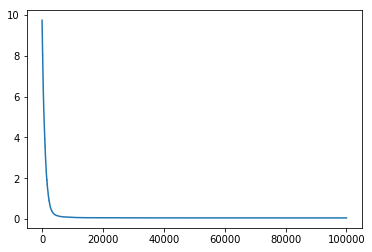

In [23]:
plt.plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
plt.show()